In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict


import netCDF4 as nc

from salishsea_tools import evaltools as et, places
import xarray as xr

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
Stratogem=pd.read_excel('/ocean/ksuchy/MOAD/observe/StratogemMicrozoopData.xlsx',engine='openpyxl')

In [3]:
Stratogem

,Unnamed: 0,Unnamed: 1,Biomass (mm3L-1),Cruise,Year,Month,Day,Date,Diatoms,Asterionellopsis glacialis,...,Ebria tripartita,Flagellates,Mesodinium rubrum,Dictyocha speculum,Dictyocha speculum askeletal,Euglenoids,Cryptophytes,Heterotrophic Dinolagellates,Mixotrophic Dinoflagellates,Other Flagellates
0,station 4-1,NaN,NaN,201.0,2002.0,4.0,11.0,2002-04-11 14:24:00,9.213466e+06,0.0,...,0.0,4450.950,594201.8250,0.0000,0.0,0.0000,12178.6470,0.0000,33585.5970,16629.5970
1,5m deep,NaN,NaN,202.0,2002.0,5.0,9.0,2002-05-09 14:24:00,7.393049e+05,0.0,...,0.0,4133.025,138647.0925,10336.8015,0.0,0.0000,27581.0535,0.0000,129694.3245,42050.8800
2,NaN,NaN,NaN,203.0,2002.0,6.0,5.0,2002-06-05 14:24:00,2.513265e+06,0.0,...,0.0,7948.125,415941.2775,10336.8015,0.0,11824.6905,296944.0695,0.0000,111161.4165,327053.6865
3,NaN,NaN,NaN,204.0,2002.0,7.0,10.0,2002-07-10 14:24:00,4.486982e+04,0.0,...,0.0,18121.725,19806.7275,0.0000,0.0,35474.0715,194500.1565,25965.9945,227750.8725,248095.9530
4,NaN,NaN,NaN,206.0,2002.0,8.0,7.0,2002-08-07 14:24:00,2.392598e+05,0.0,...,0.0,18121.725,792269.1000,0.0000,0.0,25338.6225,199514.8935,0.0000,50378.3955,242975.2410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
Stratogem.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'Biomass (mm3L-1)', 'Cruise', 'Year',
       'Month', 'Day', 'Date', 'Diatoms', 'Asterionellopsis glacialis',
       'Attheya septentrionalis', 'Chaetoceros atlanticus',
       'Chaetoceros compressus', 'Chaetoceros convolutus',
       'Chaetoceros curvisetus', 'Chaetoceros decipiens',
       'Chaetoceros didymus', 'Chaetoceros lasciniosus',
       'Chaetoceros radicans', 'Chaetoceros similis', 'Chaetoceros socialis',
       'Chaetoceros spp.', 'Climacodium sp.', 'Corethron criophilum',
       'Cylindrotheca closterium', 'Detonula pumila',
       'Dactyliosolen fragilissimus', 'Ditylum brightwellii',
       'Eucampia zodiacus', 'Haslea wrarikae', 'Guinardia delicatula',
       'Gyrosigma sp.', 'Leptocylindrus minimus', 'Odontella longicruris',
       'Pseudo-nitszchia cf. australis', 'Pseudo-nitszchia cf. delicatula',
       'Rhizosolenia setigera', 'Skeletonema costatum', 'Stephanopixis turris',
       'Synedra sp.', 'Thalassionema nitszchioides', 'T

In [5]:
#Stratogem['YD']=et.datetimeToYD(Stratogem['Date'])

In [6]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [7]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [8]:
Stratogem['L10Diatoms']=logt(Stratogem['Diatoms'])
Stratogem['L10Mesodinium']=logt(Stratogem['Mesodinium rubrum'])
Stratogem['L10Dinoflagellates']=logt(Stratogem['Dinoflagellates'])
Stratogem['L10HeteroDinos']=logt(Stratogem['Heterotrophic Dinolagellates'])
Stratogem['L10MixoDinos']=logt(Stratogem['Mixotrophic Dinoflagellates'])
Stratogem['L10Flagellates']=logt(Stratogem['Other Flagellates'])

In [9]:
monthlymean=Stratogem.groupby(['Month']).mean()
monthlysem=Stratogem.groupby(['Month']).sem()

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1510: RuntimeWarning: divide by zero encountered in true_divide
  result.iloc[:, cols].values / np.sqrt(self.count().iloc[:, cols]).values


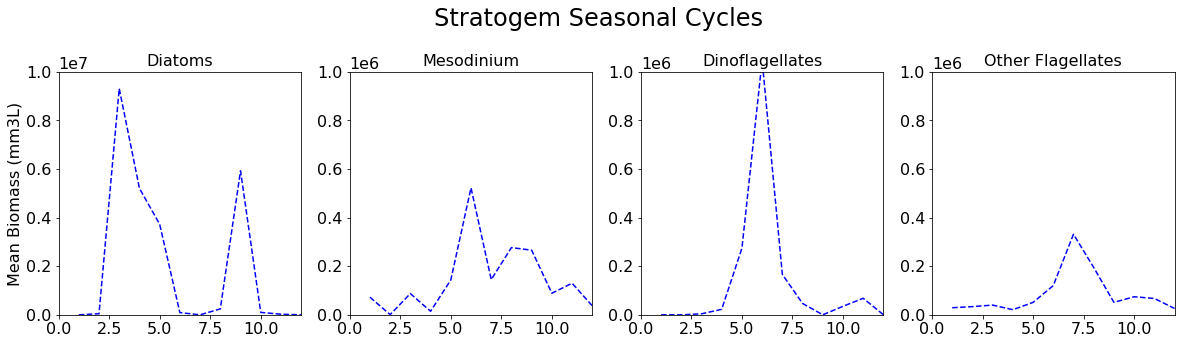

In [10]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
fig.suptitle('Stratogem Seasonal Cycles', fontsize=24)
fig.subplots_adjust(top=0.8)
#ax[0].errorbar(monthlymean.index,(monthlymean['L10Flagellates']),
#               yerr=(np.array([monthlymean['L10Flagellates']-monthlysem['L10Flagellates'],
#                 monthlymean['L10Flagellates']+monthlysem['L10Flagellates']])),
#              fmt='ro',capsize=5)
ax[0].plot(logt_inv(monthlymean['L10Diatoms']),'b--')
#ax[1].errorbar(monthlymean.index,(monthlymean['L10Mesodinium']),
#               yerr=(np.array([monthlymean['L10Mesodinium']-monthlysem['L10Mesodinium'],
#                 monthlymean['L10Mesodinium']+monthlysem['L10Mesodinium']])),
#              fmt='ro',capsize=5)
ax[1].plot(logt_inv(monthlymean['L10Mesodinium']),'b--')
#ax[2].errorbar(monthlymean.index,(monthlymean['L10Diatoms']),
#               yerr=(np.array([monthlymean['L10Diatoms']-monthlysem['L10Diatoms'],
#                 monthlymean['L10Diatoms']+monthlysem['L10Diatoms']])),
#               fmt='ro',capsize=5)
ax[2].plot(logt_inv(monthlymean['L10Dinoflagellates']),'b--')
#ax[3].errorbar(monthlymean.index,(monthlymean['L10SmallPhyto']),
#               yerr=(np.array([monthlymean['L10SmallPhyto']-monthlysem['L10SmallPhyto'],
#                 monthlymean['L10SmallPhyto']+monthlysem['L10SmallPhyto']])),
#               fmt='ro',capsize=5)
ax[3].plot(logt_inv(monthlymean['L10Flagellates']),'b--')
#ax[4].plot(logt_inv(monthlymean['L10Flagellates']),'b--')
ax[0].set_title('Diatoms')
ax[1].set_title('Mesodinium')
ax[2].set_title('Dinoflagellates')
ax[3].set_title('Other Flagellates')
#ax[4].set_title('Other Flagellates')
ax[0].set_ylabel('Mean Biomass (mm3L)')
ax[0].set_xlim(0,12)
ax[1].set_xlim(0,12)
ax[2].set_xlim(0,12)
ax[3].set_xlim(0,12)
#ax[4].set_xlim(0,12)
ax[0].set_ylim(0,10000000)
ax[1].set_ylim(0,1000000)
ax[2].set_ylim(0,1000000)
ax[3].set_ylim(0,1000000)
#ax[4].set_ylim(0,1000000)
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax[4].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [11]:
flist=['/data/sallen/results/MEOPAR/averages/SalishSea_jan_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_feb_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_mar_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_apr_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_may_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_jun_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_jul_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_aug_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_sep_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_oct_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_nov_climate_2007_2019_ptrc_T.nc',
       '/data/sallen/results/MEOPAR/averages/SalishSea_dec_climate_2007_2019_ptrc_T.nc']

In [12]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['S3']['NEMO grid ji']
ik=5 # choose surface level

In [13]:
%%time
# create empty numpy arrays of shape of desired timeseries (1 dimension, length of flist)
micZ= np.zeros((12,)) # array to hold microzo conc
diat= np.zeros((12,)) # array to hold diatom conc
mesZ=np.zeros((12,)) # array to hold diatom conc
for ind, fname in enumerate(flist):
    with nc.Dataset(fname) as ff:
        micZ[ind]=ff.variables['microzooplankton'][:,ik,ij,ii]
        diat[ind]=ff.variables['diatoms'][:,ik,ij,ii]
        mesZ[ind]=ff.variables['mesozooplankton'][:,ik,ij,ii]

CPU times: user 3.62 s, sys: 591 ms, total: 4.21 s
Wall time: 6.81 s


In [14]:
#ff=nc.Dataset(flist[0])
#ff

Text(0, 0.5, 'Concentration ($\\mu$M N)')

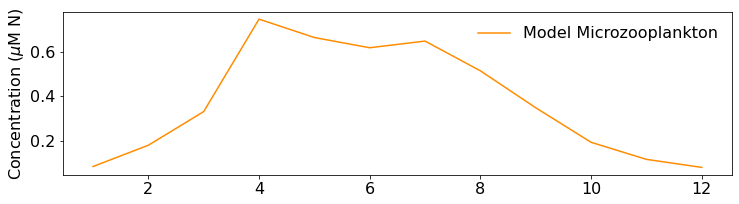

In [15]:

fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(np.arange(1,13),micZ,'-',color='darkorange',label='Model Microzooplankton')
#ax.plot(np.arange(1,13),mesZ,'-',color='blue',label='Model Mesozooplankton')
ax.legend(loc=1,frameon=False);
ax.set_ylabel('Concentration ($\mu$M N)')